In [1]:
%load_ext autoreload
%autoreload 2
import itertools
import numpy as np
import numpy.ma as ma
import matplotlib
import matplotlib.pyplot as plt
%matplotlib notebook
import matplotlib.cm as cm
import matplotlib.ticker as ticker
import matplotlib.dates as dates
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import ImageGrid, make_axes_locatable, host_subplot
#from mpl_toolkits.basemap import Basemap
from datetime import datetime, timedelta
import sys
import os
import pyPIPS.utils as utils
import pyPIPS.thermolib as thermo
import pyPIPS.DSDlib as dsd
#import pyPIPS.disdrometer_module as dis
import pyPIPS.plotmodule as PIPSplot
#import pyPIPS.simulator as sim
import pyPIPS.pips_io as pipsio
import pyPIPS.PIPS as pips
import pyPIPS.parsivel_params as pp
import pyPIPS.parsivel_qc as pqc
import pyPIPS.radarmodule as radar
import pyPIPS.polarimetric as dualpol
import pyPIPS.timemodule as tm

#from pyCRMtools.modules import plotmodule as plotmod
from pyCRMtools.modules import utils as CRMutils
import pandas as pd
import xarray as xr
import glob
import numpy.random as random
from scipy.stats import gamma, uniform
from scipy.special import gamma as gammafunc
from scipy import ndimage
from scipy import interpolate
from metpy.plots import StationPlot
import metpy.calc as mpcalc
from metpy.calc import wind_components
from metpy.cbook import get_test_data
from metpy.plots import StationPlot
from metpy.plots.wx_symbols import current_weather, sky_cover
from metpy.units import units
from scipy.signal import medfilt2d
import pyart
import cartopy.crs as ccrs
from io import StringIO
from IPython.display import HTML
%matplotlib inline
# %matplotlib notebook
import warnings;
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

/Users/dawson29/Projects/pyPIPS/pyPIPS/PIPS.py:609: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def calc_empirical_fallspeed(d, correct_rho=False, rho=None):



## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/Users/dawson29/Projects/pyPIPS/pyPIPS/DSDlib.py:1085: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def fit_DSD_TMM246(M2, M4, M6, D_min, D_max):
/Users/dawson29/Projects/pyPIPS/pyPIPS/DSDlib.py:1170: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def fit_DSD_TMM234(M2, M3, M4, D_min, D_max):
/Users/dawson29/Projects/pyPIPS/pyPIPS/DSDlib.py:1611: NumbaDeprecatio

In [2]:
# Function definitions
def readESC(sounding_path, interpnan=True, handle=False):
    """
    Reads in a sounding in ESC format from a provided file path or handle (can be a StringIO object or an open
    file handle)
    """
    col_names = ['pressure','temperature','dewpoint','u_wind','v_wind','speed','direction','height',
                 'Qp_code','Qt_code','Qrh_code','Qu_code','Qv_code']
    # First read the file and extract the field widths from the 14th header line
    if not handle:
        f = open(sounding_path, 'r')
    else:
        f = sounding_path

    # Read in the header and extract some metadata from it
    dummy = f.readline()
    dummy = f.readline()
    header2 = f.readline().strip().split(':')
    # Read next header line and extract station id and wmo number from it (if it exists)
    staid_wmo_str = header2[1]
    if ' / ' in staid_wmo_str:
        staid_wmo = staid_wmo_str.strip().split(' / ')
        staid = staid_wmo[0][1:4]
        wmo = int(staid_wmo[1])
    else:
        if '. ' in staid_wmo_str:
            staid = staid_wmo_str.replace('. ', '').strip()[:4]
        else:
            staid = staid_wmo_str.strip()[:4]
            staid = staid.replace(" ", "")
        wmo = 99999
    print(staid)
    # Read the next header line and extract the location information from it
    header3 = f.readline().strip().split(':')
    location = header3[1].strip().split(',')
    print(location)
    lon = float(location[2])
    lat = float(location[3])
    elev = float(location[4])
    # Read the next header line and extract the time information from it
    header4 = f.readline().strip()[31:].lstrip()   
    sounding_datetime = datetime.strptime(header4, '%Y, %m, %d, %H:%M:%S')
    
    # Now read and dump the rest of the header
    for i in range(9):
        f.readline()
    
    # Except for the last header line, which is used to determine the widths of the fields
    line = f.readline().strip().split()
    fw = [len(field)+1 for field in line]

    # Now read the file into the dataframe, using the extracted field widths
    df = pd.read_fwf(f, usecols=[1, 2, 3, 5, 6, 7, 8, 14, 15, 16, 17, 18, 19],
                     names=col_names, na_values=['99999.0', '9999.0', '999.0'], widths=fw)
    
    # For some reason, need to convert all the columns to floating point here, as some get interpreted as strings
    # when they shouldn't be...
    # print(df['pressure'], df['temperature'])
    for column in df.columns:
        df[column] = df[column].astype(float)
    
    # Drop rows where height or pressure is NaN. TODO: Can't remember why I have to use reset_index(drop=True). 
    # Figure this out.
    df = df.dropna(subset=('height', 'pressure')).reset_index(drop=True)
    # Set the height as the index so we can use it as weights to interpolate other columns across NaN
    df = df.set_index('height')
    df['height'] = df.index
    
    if interpnan:
        # First convert direction and speed to u, v components
        df['u'], df['v'] = mpcalc.wind_components(df['speed'].values*units('m/s'),
                                                      df['direction'].values*units.degrees)
        # Now interpolate
        df = df.interpolate(method='values')
        # Finally recompute direction and speed from u, v components
        df['speed'] = mpcalc.wind_speed(df['u'].values*units('m/s'), df['v'].values*units('m/s'))
        df['direction'] = mpcalc.wind_direction(df['u'].values*units('m/s'), df['v'].values*units('m/s'))
    else:
        # Drop any rows with all NaN values for T, Td, winds
        df = df.dropna(subset=('temperature', 'dewpoint', 'direction', 'speed',
                               'u_wind', 'v_wind'), how='all').reset_index(drop=True)
    
    df = df[(df.Qp_code == 1.0) & (df.Qt_code == 1.0) & (df.Qrh_code == 1.0) & (df.Qu_code == 1.0) & 
            (df.Qv_code == 1.0)]

    nlines = df.count()['pressure']
    
    if not handle:
        f.close()
    
    snd_metadata = {
        'sounding_datetime': sounding_datetime,
        'lat': lat,
        'lon': lon,
        'selev': elev,
        'staid': staid,
        'wmo': wmo,
        'nlevs': nlines,
        'staid_long': staid_wmo_str
    }
    
    return snd_metadata, df


def readsharppy(path):
    """Reads in a sounding in sharppy format"""
        ## read in the file
    f = open(path, 'r')
    lines = f.read()
    data = np.array([l.strip() for l in lines.split('\n')])
    f.close()

    ## necessary index points
    title_idx = np.where( data == '%TITLE%')[0][0]
    start_idx = np.where( data == '%RAW%' )[0][0] + 1
    finish_idx = np.where( data == '%END%')[0][0]
    
    ## create the plot title
    data_header = data[title_idx + 1].split()
    location = data_header[0]
    time = data_header[1][:11]

    ## put it all together for StringIO
    full_data = '\n'.join(data[start_idx : finish_idx][:])
    sound_data = StringIO( full_data )

    ## read the data into arrays
    p, h, T, Td, wdir, wspd = np.genfromtxt( sound_data, delimiter=',', comments="%", unpack=True )
    
    col_names = ['pressure','height','temperature','dewpoint','speed','direction']
    data_dict = {key:value for (key,value) in zip(col_names,[p,h,T,Td,wspd,wdir])}
    
    df = pd.DataFrame.from_dict(data_dict)
    
    return df


def roundPartial(value, resolution, decimals=4):
    return np.around(np.round(value / resolution) * resolution, decimals=decimals)


def rain_Brandes(D):
    """Given a range of diameters D, compute rain fall speed curve, a quartic polynomial
       fit after Brandes et al. (2002)."""
    
    D_mm=D*1000. # get it to (mm)
    
    Vtr = -0.1021 + 4.932*D_mm - 0.9551*D_mm**2. + 0.07934*D_mm**3. - 0.002362*D_mm**4.
    
    return Vtr


def mtokm(val,pos):
    """Convert m to km for formatting axes tick labels"""
    val=val/1000.0
    return '%i' % val

def plot_animation(xplt, yplt, field, clevels, cbarlabel=None, cbarintv=None, cmap='pyart_HomeyerRainbow', 
                   norm=None, PIPS_ds_dict=None, PIPS_list=None, 
                   PIPS_rad_loc_dict=None, ax=None, ptype='pcolor', axestickintv=10000., 
                   axeslimits=None):
    
    # Find nice text label positions for the PIPS overlays
    if PIPS_list is not None and PIPS_rad_loc_dict is not None and PIPS_ds_dict is not None:
        PIPS_x_dict = {PIPS_name: PIPS_rad_loc_dict[PIPS_name][0] for PIPS_name in PIPS_list}
        PIPS_y_dict = {PIPS_name: PIPS_rad_loc_dict[PIPS_name][1] for PIPS_name in PIPS_list}
        text_x_dict = {PIPS_name: PIPS_x_dict[PIPS_name] + 500. for PIPS_name in PIPS_list}
        text_y_dict = {PIPS_name: PIPS_y_dict[PIPS_name] + 500. for PIPS_name in PIPS_list}
        
        for PIPS_pair in itertools.combinations(PIPS_list, 2):
            if (np.abs(text_x_dict[PIPS_pair[0]] - text_x_dict[PIPS_pair[1]]) < 500. and
                np.abs(text_y_dict[PIPS_pair[0]] - text_y_dict[PIPS_pair[1]]) < 500.):
                text_y_dict[PIPS_pair[0]] -= 1000.
    
    if norm is None:
        norm = cm.colors.Normalize(vmin=clevels[0], vmax=clevels[-1])
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 8))
    else:
        fig = ax.get_figure()
    ims = []
    for i, var in enumerate(var_da):
        plotdata = []
        time_dt64 = var.coords['time'].values
        time = np.datetime_as_string(time_dt64, unit='m')  # Ugly, but whatever
        
        title = ax.text(0.5,1.05,"Time: {}".format(time), 
                        size=plt.rcParams["axes.titlesize"],
                        ha="center", transform=ax.transAxes)
        plotdata.append(title)
        
        if ptype == 'pcolor':
            if norm is None:
                ci = ax.pcolormesh(xplt, yplt, var.squeeze(), vmin=clevels[0], vmax=clevels[-1], cmap=cmap, 
                                   norm=norm)
            else:
                ci = ax.pcolormesh(xplt, yplt, var.squeeze(), cmap=cmap, norm=norm)
            plotdata.append(ci)
        else:
            ci = ax.contourf(xplt, yplt, var.squeeze(), levels=clevels, 
                             cmap=cmap, norm=norm)
            plotdata.extend(ci.collections)
            
        if PIPS_list is not None and PIPS_rad_loc_dict is not None and PIPS_ds_dict is not None:
            # Figure out which PIPS (if any) were deployed at this radar time and add them to the lists to plot
            # PIPS_names_toplot = []
            # rad_locs_toplot = []
        
            for PIPS_name, PIPS_ds in PIPS_ds_dict.items():
                PIPS_start_time = PIPS_ds.time[0].values
                PIPS_end_time = PIPS_ds.time[-1].values
                if time_dt64 >= PIPS_start_time and time_dt64 <= PIPS_end_time:
                    # PIPS_names_toplot.append(PIPS_name)
                    # rad_locs_toplot.append(rad_loc_dict[PIPS_name])
                    PIPS_x = PIPS_x_dict[PIPS_name]
                    PIPS_y = PIPS_y_dict[PIPS_name]
                    ax.plot([PIPS_x], [PIPS_y], 'k*')
                    x_text = text_x_dict[PIPS_name]
                    y_text = text_y_dict[PIPS_name]
                    ax.annotate(PIPS_name, xy=(x_text, y_text))
        
        if i == 0.:
            if cbarintv is None:
                cbarintv = clevels[1] - clevels[0]
            cbarlevels = ticker.MultipleLocator(base=cbarintv)
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.05)
            fig.colorbar(ci, orientation='vertical', ticks=cbarlevels, cax=cax)
            if cbarlabel is not None:
                cax.set_ylabel(cbarlabel)
            formatter = ticker.FuncFormatter(mtokm)
            ax.xaxis.set_major_formatter(formatter)
            ax.yaxis.set_major_formatter(formatter)
            ax.xaxis.set_major_locator(ticker.MultipleLocator(base=axestickintv))
            ax.yaxis.set_major_locator(ticker.MultipleLocator(base=axestickintv))
            ax.set_xlabel('km')
            ax.set_ylabel('km')
            if axeslimits is None:
                xmin = xplt[0]
                xmax = xplt[-1]
                ymin = yplt[0]
                ymax = yplt[-1]
            else:
                xmin, xmax, ymin, ymax = axeslimits
            ax.set_xlim(xmin, xmax)
            ax.set_ylim(ymin, ymax)
            ax.set_aspect('equal')
            
        ims.append(plotdata)
    
    ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                    repeat_delay=1000)
    plt.close()
    return ani


def plot_animation_sweep(radarsweep_list, field_name, clevels, cbarlabel=None, cbarintv=None, 
                         cmap='pyart_HomeyerRainbow', norm=None, PIPS_ds_dict=None, PIPS_list=None, 
                         PIPS_rad_loc_dict=None, 
                         ax=None, ptype='pcolor', axestickintv=10000., axeslimits=None):
    
    # Find nice text label positions for the PIPS overlays
    if PIPS_list is not None and PIPS_rad_loc_dict is not None and PIPS_ds_dict is not None:
        PIPS_x_dict = {PIPS_name: PIPS_rad_loc_dict[PIPS_name][0] for PIPS_name in PIPS_list}
        PIPS_y_dict = {PIPS_name: PIPS_rad_loc_dict[PIPS_name][1] for PIPS_name in PIPS_list}
        text_x_dict = {PIPS_name: PIPS_x_dict[PIPS_name] + 500. for PIPS_name in PIPS_list}
        text_y_dict = {PIPS_name: PIPS_y_dict[PIPS_name] + 500. for PIPS_name in PIPS_list}
        
        for PIPS_pair in itertools.combinations(PIPS_list, 2):
            if (np.abs(text_x_dict[PIPS_pair[0]] - text_x_dict[PIPS_pair[1]]) < 500. and
                np.abs(text_y_dict[PIPS_pair[0]] - text_y_dict[PIPS_pair[1]]) < 500.):
                text_y_dict[PIPS_pair[0]] -= 1000.
                
    if norm is None:
        norm = cm.colors.Normalize(vmin=clevels[0], vmax=clevels[-1])
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 8))
    else:
        fig = ax.get_figure()
    ims = []
    for i, radarsweep in enumerate(radarsweep_list):
        var = radarsweep.fields[field_name]['data']
        plotdata = []
        sweep_datetime = pyart.graph.common.generate_radar_time_sweep(radarsweep, 0)
        sweep_time_dt64 = np.datetime64(sweep_datetime)
        time = sweep_datetime.strftime('%Y-%m-%dT%H:%M')
        
        title = ax.text(0.5,1.05,"Time: {}".format(time), 
                        size=plt.rcParams["axes.titlesize"],
                        ha="center", transform=ax.transAxes)
        plotdata.append(title)
        
        if ptype == 'pcolor':
            xplt, yplt, _ = radarsweep.get_gate_x_y_z(0, edges=True)
            xplt = xplt.squeeze()
            yplt = yplt.squeeze()
            if norm is None:
                ci = ax.pcolormesh(xplt, yplt, var.squeeze(), vmin=clevels[0], vmax=clevels[-1], cmap=cmap, 
                                   norm=norm)
            else:
                ci = ax.pcolormesh(xplt, yplt, var.squeeze(), cmap=cmap, norm=norm)
            plotdata.append(ci)
        else:
            xplt, yplt, _ = radarsweep.get_gate_x_y_z(0)
            xplt = xplt.squeeze()
            yplt = yplt.squeeze()
            ci = ax.contourf(xplt, yplt, var.squeeze(), levels=clevels, 
                             cmap=cmap, norm=norm)
            plotdata.extend(ci.collections)
            
        if PIPS_list is not None and PIPS_rad_loc_dict is not None and PIPS_ds_dict is not None:
            # Figure out which PIPS (if any) were deployed at this radar time and add them to the lists to plot
            # PIPS_names_toplot = []
            # rad_locs_toplot = []
        
            for PIPS_name, PIPS_ds in PIPS_ds_dict.items():
                PIPS_start_time = PIPS_ds.time[0].values
                PIPS_end_time = PIPS_ds.time[-1].values
                if sweep_time_dt64 >= PIPS_start_time and sweep_time_dt64 <= PIPS_end_time:
                    # PIPS_names_toplot.append(PIPS_name)
                    # rad_locs_toplot.append(rad_loc_dict[PIPS_name])
                    PIPS_x = PIPS_x_dict[PIPS_name]
                    PIPS_y = PIPS_y_dict[PIPS_name]
                    ax.plot([PIPS_x], [PIPS_y], 'k*')
                    x_text = text_x_dict[PIPS_name]
                    y_text = text_y_dict[PIPS_name]
                    ax.annotate(PIPS_name, xy=(x_text, y_text))
 
        if i == 0.:
            if cbarintv is None:
                cbarintv = clevels[1] - clevels[0]
            cbarlevels = ticker.MultipleLocator(base=cbarintv)
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.05)
            fig.colorbar(ci, orientation='vertical', ticks=cbarlevels, cax=cax)
            if cbarlabel is not None:
                cax.set_ylabel(cbarlabel)
            formatter = ticker.FuncFormatter(mtokm)
            ax.xaxis.set_major_formatter(formatter)
            ax.yaxis.set_major_formatter(formatter)
            ax.xaxis.set_major_locator(ticker.MultipleLocator(base=axestickintv))
            ax.yaxis.set_major_locator(ticker.MultipleLocator(base=axestickintv))
            ax.set_xlabel('km')
            ax.set_ylabel('km')
            if axeslimits is None:
                xmin = np.min(xplt)
                xmax = np.max(xplt)
                ymin = np.min(yplt)
                ymax = np.max(yplt)
            else:
                xmin, xmax, ymin, ymax = axeslimits
            ax.set_xlim(xmin, xmax)
            ax.set_ylim(ymin, ymax)
            ax.set_aspect('equal')
            
        ims.append(plotdata)
    
    ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                    repeat_delay=1000)
    plt.close()
    return ani



def interp_pyart_grid_to_PIPS(grid_ds, PIPS_loc_list):
    """Interpolate pyart gridded radar to PIPS locations given an xarray dataset with pyart grid info and a list
       of PIPS lats, lons, and altitudes. Returns lists of PIPS x, y, and z locations in radar grid coordinates
       and a list of xarray Datasets for each grid variable interpolated to each PIPS location."""

    # TODO: instead of returning lists, maybe make the PIPS name a dimension of a new xarray Dataset
    
    ctrlat = float(grid_ds.origin_latitude)
    ctrlon = float(grid_ds.origin_longitude)
    print(ctrlat, ctrlon)

    radar_at_PIPS_list = []
    PIPS_x_list = []
    PIPS_y_list = []
    PIPS_z_list = []

    for PIPS_loc in PIPS_locs:
        PIPS_lat = PIPS_loc[0]
        PIPS_lon = PIPS_loc[1]
        PIPS_alt = PIPS_loc[2]
        radar_alt = float(grid_ds.origin_altitude)
        
        PIPS_z = PIPS_alt - radar_alt
        PIPS_z_list.append(PIPS_z)
        # Use this function to get the x and y coords of the PIPS. Note that this will only be correct 
        # if the radar
        # grid was created using the default pyart aeqd projection.
        PIPS_x, PIPS_y = pyart.core.geographic_to_cartesian_aeqd(PIPS_lon, PIPS_lat, ctrlon, ctrlat)
        PIPS_x = PIPS_x.squeeze().item()
        PIPS_y = PIPS_y.squeeze().item()
        PIPS_x_list.append(PIPS_x)
        PIPS_y_list.append(PIPS_y)
        print('PIPS lat, lon, alt: ', PIPS_lat, PIPS_lon, PIPS_alt)
        print('PIPS x, y, z: ', PIPS_x, PIPS_y, PIPS_z)
        radar_at_PIPS_ds = grid_ds.interp(x=PIPS_x, y=PIPS_y)
        radar_at_PIPS_list.append(radar_at_PIPS_ds)

    return PIPS_x_list, PIPS_y_list, PIPS_z_list, radar_at_PIPS_list

In [3]:
# Read in the files containing the original radar sweeps
radar_name = 'KGWX'
radar_type= 'NEXRAD'
elev_angle = 0.5
elev_str = str(elev_angle).replace('.', 'p')
elev_tol = 0.1

date = '0330'
radar_start_datetimestamp = '20220330233252' # '20220330220424'
radar_end_datetimestamp = '20220331011617' # '20220331035633'

# Create datetime objects for start and end times
datetime_start = datetime.strptime(radar_start_datetimestamp, '%Y%m%d%H%M%S')
datetime_end = datetime.strptime(radar_end_datetimestamp, '%Y%m%d%H%M%S')

radar_basedir = \
    '/Users/dawson29/Projects/PERiLS/obsdata/2022/NEXRAD/IOP2/KGWX'
#radar_basedir = os.path.join(radar_basedir, '{}/{}'.format(date, radar_name[1:]))
radar_input_dir = os.path.join(radar_basedir, 'extracted_sweeps')
radar_output_dir = os.path.join(radar_basedir, 'extracted_sweeps')
if not os.path.exists(radar_output_dir):
    os.makedirs(radar_output_dir)

radar_start_timestamp = datetime_start.strftime('%Y%m%d%H%M')
radar_end_timestamp = datetime_end.strftime('%Y%m%d%H%M')

radar_paths = glob.glob(radar_input_dir + f'/{radar_name}*el{elev_str}_filt_retr.nc')

radar_paths = sorted(radar_paths)
radar_input_list = []

for path in radar_paths:
    filename = os.path.basename(path)
    file_timestamp = filename[4:19]
    # print(file_timestamp)
    file_datetime = datetime.strptime(file_timestamp, '%Y%m%d_%H%M%S')
    if file_datetime >= datetime_start and file_datetime <= datetime_end:
        radar_input_list.append(path)

# Read in the individual sweeps
radarobj_list = []
for radar_path in radar_input_list:
    print(f"Reading {os.path.basename(radar_path)}")
    radarobj = pyart.io.read(radar_path)
    radarobj_list.append(radarobj)

Reading KGWX20220330_233252_el0p5_filt_retr.nc
Reading KGWX20220330_233335_el0p5_filt_retr.nc
Reading KGWX20220330_233419_el0p5_filt_retr.nc
Reading KGWX20220330_233502_el0p5_filt_retr.nc
Reading KGWX20220330_233952_el0p5_filt_retr.nc
Reading KGWX20220330_234033_el0p5_filt_retr.nc
Reading KGWX20220330_234114_el0p5_filt_retr.nc
Reading KGWX20220330_234155_el0p5_filt_retr.nc
Reading KGWX20220330_234639_el0p5_filt_retr.nc
Reading KGWX20220330_234720_el0p5_filt_retr.nc
Reading KGWX20220330_234801_el0p5_filt_retr.nc
Reading KGWX20220330_234842_el0p5_filt_retr.nc
Reading KGWX20220330_235324_el0p5_filt_retr.nc
Reading KGWX20220330_235403_el0p5_filt_retr.nc
Reading KGWX20220330_235442_el0p5_filt_retr.nc
Reading KGWX20220330_235521_el0p5_filt_retr.nc
Reading KGWX20220330_235959_el0p5_filt_retr.nc
Reading KGWX20220331_000037_el0p5_filt_retr.nc
Reading KGWX20220331_000114_el0p5_filt_retr.nc
Reading KGWX20220331_000152_el0p5_filt_retr.nc
Reading KGWX20220331_000624_el0p5_filt_retr.nc
Reading KGWX2

In [4]:
radarobj_list[0].info()

altitude:
	data: <ndarray of type: float64 and shape: (1,)>
	_FillValue: -9999.0
	long_name: altitude
	units: meters
	positive: up
altitude_agl:
	data: <ndarray of type: float64 and shape: (1,)>
	_FillValue: -9999.0
	long_name: altitude_above_ground_level
	units: meters
	positive: up
antenna_transition:
	data: <ndarray of type: int8 and shape: (720,)>
	_FillValue: -128
	long_name: antenna_is_in_transition_between_sweeps
	units: 
	comment: 1 if antenna is in transition, 0 otherwise
azimuth:
	data: <ndarray of type: float32 and shape: (720,)>
	_FillValue: -9999.0
	long_name: ray_azimuth_angle
	units: degrees
elevation:
	data: <ndarray of type: float32 and shape: (720,)>
	_FillValue: -9999.0
	long_name: ray_elevation_angle
	units: degrees
	positive: up
fields:
	REF:
		data: <ndarray of type: float32 and shape: (720, 1832)>
		_FillValue: -128.0
		long_name: radar_reflectivity
		units: dBZ
		standard_name: equivalent_reflectivity_factor
		sampling_ratio: 1.0
		grid_mapping: grid_mapping
		c

In [5]:
# Read in the time-interpolated radar-derived DSDs on the original elevation angle
radar_DSD_start_datetimestamp = '20220330233000'
radar_DSD_end_datetimestamp = '20220331011500'

# Create datetime objects for start and end times
datetime_start = datetime.strptime(radar_DSD_start_datetimestamp, '%Y%m%d%H%M%S')
datetime_end = datetime.strptime(radar_DSD_end_datetimestamp, '%Y%m%d%H%M%S')

radar_DSD_start_timestamp = datetime_start.strftime('%Y%m%d%H%M')
radar_DSD_end_timestamp = datetime_end.strftime('%Y%m%d%H%M')

radar_DSD_filename = '{}_{}_{}_el{}_radar_DSDs.nc'.format(radar_name, radar_DSD_start_timestamp, 
                                                          radar_DSD_end_timestamp, elev_str)
radar_DSD_filepath = os.path.join(radar_input_dir, radar_DSD_filename)
radar_DSD_ds = xr.open_dataset(radar_DSD_filepath)

In [6]:
# Read in the gridded radar-derived DSDs at bottom of sorting layer
radar_sorted_start_datetimestamp = '20220330233000'
radar_sorted_end_datetimestamp = '20220331011500'

# Create datetime objects for start and end times
datetime_start = datetime.strptime(radar_sorted_start_datetimestamp, '%Y%m%d%H%M%S')
datetime_end = datetime.strptime(radar_sorted_end_datetimestamp, '%Y%m%d%H%M%S')

radar_sorted_start_timestamp = datetime_start.strftime('%Y%m%d%H%M')
radar_sorted_end_timestamp = datetime_end.strftime('%Y%m%d%H%M')

freq = '30S'

gridded_radar_sorted_filename = '{}_{}_{}_el{}_{}_sorted.nc'.format(radar_name, 
                                                                 radar_sorted_start_timestamp, 
                                                                 radar_sorted_end_timestamp, 
                                                                 elev_str, freq)
gridded_radar_sorted_filepath = os.path.join(radar_input_dir, gridded_radar_sorted_filename)
gridded_radar_sorted_ds = xr.open_dataset(gridded_radar_sorted_filepath)

In [7]:
# Extract x and y coordinates from sorted grid file. These represent the *left* edges of the grid cells,
# not the centers, and are therefore missing the final *right* edge. This is because of the way I constructed
# the coordinates. I really should have used the grid centers. Anyway, add the final edge here and then
# calculate the grid centers
# TODO: go back and fix this in the calc_precip_trajectories... notebook

xedges = gridded_radar_sorted_ds.coords['x'].values
dx = xedges[1] - xedges[0]
xedges = np.append(xedges, xedges[-1] + dx)

yedges = gridded_radar_sorted_ds.coords['y'].values
dy = yedges[1] - yedges[0]
yedges = np.append(yedges, yedges[-1] + dy)

xctr = 0.5 * (xedges[1:] + xedges[:-1])
yctr = 0.5 * (yedges[1:] + yedges[:-1])

In [8]:
plot_dir = os.path.join(radar_output_dir, 'plots')
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

In [9]:
# Read in PIPS data
# deployment = 'IOP1A_D1_2017'
# PIPS_list = ['PIPS1A', 'PIPS1B', 'PIPS2B']
# PIPS_data_dir = '/Volumes/scr_fast/Projects/VORTEXSE/obsdata/full_PIPS_dataset_RB15'

deployment = 'IOP2_033022'
PIPS_list = ['PIPS1A', 'PIPS1B', 'PIPS2A', 'PIPS3B']
PIPS_data_dir = '/Users/dawson29/Projects/PERiLS/obsdata/2022/PIPS_data/IOP2_033022/netcdf'


PIPS_ds_list = []
PIPS_locs = []

for PIPS in PIPS_list:
    PIPS_filename = 'parsivel_combined_{}_{}_60s_filt2_retr.nc'.format(deployment, PIPS)
    PIPS_filepath = os.path.join(PIPS_data_dir, PIPS_filename)
    PIPS_ds = xr.load_dataset(PIPS_filepath)
    PIPS_ds_list.append(PIPS_ds)
    PIPS_loc = eval(PIPS_ds.location)
    PIPS_locs.append(PIPS_loc)

In [10]:
# Find PIPS x, y location relative to radar by interpolating to its lat/lon point

rlat = radarobj_list[0].latitude['data'][0]
rlon = radarobj_list[0].longitude['data'][0]
ralt = radarobj_list[0].altitude['data'][0]

PIPS_x_list = []
PIPS_y_list = []
PIPS_z_list = []

geo_loc_dict = {}
rad_loc_dict = {}

PIPS_ds_dict = {PIPS_name: PIPS_ds for PIPS_name, PIPS_ds in zip(PIPS_list, PIPS_ds_list)}

geo_loc_dict = {}
rad_loc_dict = {}
for PIPS_name, PIPS_ds in PIPS_ds_dict.items():
    geo_loc_str = PIPS_ds.location
    geo_loc = list(map(float, geo_loc_str.strip('()').split(',')))
    geo_loc_dict[PIPS_name] = geo_loc
    rad_loc = radar.get_PIPS_loc_relative_to_radar(geo_loc, rlat, rlon, ralt)
    rad_loc_dict[PIPS_name] = rad_loc
    PIPS_x_list.append(rad_loc[0])
    PIPS_y_list.append(rad_loc[1])
    PIPS_z_list.append(rad_loc[2])
    
PIPS_z_mean = np.array(PIPS_z_list).mean()
print(PIPS_z_list)
print(PIPS_z_mean)
PIPS_x_arr = np.array(PIPS_x_list)
PIPS_y_arr = np.array(PIPS_y_list)

print(PIPS_x_arr, PIPS_y_arr)

PIPS_xy_list = [(PIPS_x, PIPS_y) for PIPS_x, PIPS_y in zip(PIPS_x_list, PIPS_y_list)]

Radar location (lat, lon, alt) 33.896915435791016 -88.32919311523438 179.0
Disdrometer location (lat, lon, alt) 33.75801086325083 -88.44616666666666 70.7434820494946
PIPS location relative to radar (x, y, z) -10813.806115689142 -15439.327656729798 -108.2565179505054
Radar location (lat, lon, alt) 33.896915435791016 -88.32919311523438 179.0
Disdrometer location (lat, lon, alt) 33.71500000000001 -88.45050000000002 66.61888437828897
PIPS location relative to radar (x, y, z) -11220.039260227966 -20221.4503250962 -112.38111562171103
Radar location (lat, lon, alt) 33.896915435791016 -88.32919311523438 179.0
Disdrometer location (lat, lon, alt) 33.82966666666666 -88.45933333333333 73.6733731892389
PIPS location relative to radar (x, y, z) -12020.943833369885 -7470.109111668025 -105.3266268107611
Radar location (lat, lon, alt) 33.896915435791016 -88.32919311523438 179.0
Disdrometer location (lat, lon, alt) 33.829666666666654 -88.45933333333333 104.94753711996229
PIPS location relative to radar

In [12]:
# Read in sounding file to get low-level wind field and then derive storm-relative wind
# Storm motion taken from subjective reflectivity tag tracking using GRLevel2
# EDIT: don't need storm motion because it is implicitly handled in time-dependent trajectory model
# ustorm = 12.51
# vstorm = 12.95

# EDIT: setting ustorm, vstorm to 0 to force ground-relative flow
ustorm = 0.
vstorm = 0.

# sounding_dir = '/Volumes/scr_fast/Projects/VORTEXSE/obsdata/2017/soundings'
# sounding_filename = 'Courtland_1759.txt'
# # sounding_dir = '/Users/dawson29/sshfs_mounts/depot/data/Projects/VORTEXSE/obsdata/2017/soundings/COMP5mb'
# # sounding_filename = 'Hollywood_201704301954.cls'
# sounding_path = os.path.join(sounding_dir, sounding_filename)
# sounding_metadata, sounding_df = readESC(sounding_path)

# For PERiLS IOP2 UIUC SONDE4
sounding_dir = '/Users/dawson29/sshfs_mounts/depot/data/Projects/PERiLS/obsdata/2022/non-radar_QC_Illinois/20220330_IOP02/SONDE4/sounding/L2'
sounding_filename = 'SPC_20220330_SONDE4_2328.txt'
sounding_path = os.path.join(sounding_dir, sounding_filename)

sounding_df = readsharppy(sounding_path)
wind_dir = sounding_df['direction'].values*units.degrees
# print(wind_dir)
wind_speed_kts = sounding_df['speed'].values*units.knots 
wind_speed_ms = wind_speed_kts.to(units('m/s'))

# print(wind_speed_ms)
u, v = wind_components(wind_speed_ms, wind_dir)

sounding_df['u'] = u
sounding_df['v'] = v

In [13]:
print(sounding_df)

     pressure  height  temperature  dewpoint  speed  direction          u  \
0       994.0    62.1        21.50     18.54  12.05     169.98  -1.078586   
1       993.7    65.0        21.72     18.73  12.17     169.99  -1.088251   
2       993.1    70.0        21.87     18.80  12.58     170.00  -1.123801   
3       992.5    75.0        21.98     18.82  12.97     169.99  -1.159787   
4       992.0    80.0        22.07     18.83  13.35     169.99  -1.193767   
..        ...     ...          ...       ...    ...        ...        ...   
846     596.3  4290.0        -5.00     -6.84  85.72     205.00  18.636695   
847     595.9  4295.0        -5.00     -6.83  85.72     205.00  18.636695   
848     595.5  4300.0        -4.97     -6.80  85.72     205.00  18.636695   
849     595.1  4305.0        -4.90     -6.77  85.72     205.00  18.636695   
850     594.8  4310.0        -5.03     -7.02  85.72     205.00  18.636695   

             v  
0     6.104502  
1     6.165484  
2     6.373391  
3     6

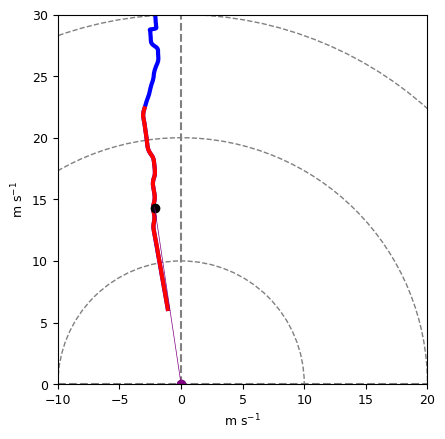

In [14]:
from metpy.plots import SkewT, Hodograph

height = 500.

# ustorm, vstorm = (4.121136597951332, 6.968096312979091) # From mean of pysteps u and v field (04/30)
# ustorm, vstorm = (4.893569553782078, 2.6387864245583765) # 03/27
# ustorm, vstorm = (3.164247877224066, 5.370989998643443) #03/25
ustorm, vstorm = (0., 0.)  # Get this value for PERiLS IOP2 case!

hodo_units='m/s'

u = sounding_df['u']
v = sounding_df['v']
z = sounding_df['height'] # - sounding_metadata['selev']

u1km = u.loc[z <= height]
v1km = v.loc[z <= height]

u1kmavg = u1km.mean()
v1kmavg = v1km.mean()

ug1km = u.loc[~(z <= height)]
vg1km = v.loc[~(z <= height)]

hodo = Hodograph(component_range=40)
hodo.add_grid(increment=10)
if(hodo_units == 'm/s'):
    hodo.plot(u, v, color='b')
    hodo.plot(u1km, v1km, color='r')
    hodo.plot(u1kmavg, v1kmavg, color='k', marker='o')
    hodo.plot(ustorm, vstorm, color='purple', marker='o')
    hodo.plot([ustorm, u1kmavg], [vstorm, v1kmavg], color='purple', linewidth=0.5)
    hodo.ax.set_xlim(-10., 20.)
    hodo.ax.set_ylim(0., 30.)
    hodo.ax.set_xlabel(r'm s$^{-1}$')
    hodo.ax.set_ylabel(r'm s$^{-1}$')
else:
    hodo.plot(u,v)
    hodo.ax.set_xlabel('kts')
    hodo.ax.set_ylabel('kts')
#hodo.ax.set_xlim(-10.,40.)

plot_filename = '{}_hodo.png'.format(sounding_filename[:-4]) 
plot_filepath = os.path.join(plot_dir, plot_filename)
plt.savefig(plot_filepath, dpi=300, bbox_inches='tight')

In [ ]:
# Set up start and end time objects and strings for animations
# 04/30 case
# anim_start = '2017-04-30T20:00'
# anim_end = '2017-04-30T21:30'

# 03/25 case
# anim_start = '2017-03-25T17:00'
# anim_end = '2017-03-25T18:45'

# PERiLS IOP2
anim_start = '2022-03-30T23:30'
anim_end = '2022-03-31T01:15'

anim_start_datetime = datetime.strptime(anim_start, '%Y-%m-%dT%H:%M')
anim_end_datetime = datetime.strptime(anim_end, '%Y-%m-%dT%H:%M')

anim_start_out = anim_start_datetime.strftime('%Y%m%d%H%M')
anim_end_out = anim_end_datetime.strftime('%Y%m%d%H%M')

ref_varname = 'REF'
zdr_varname = 'ZDR'
rhv_varname = 'RHO'

matplotlib.rcParams['animation.embed_limit'] = 2**128

In [ ]:
PIPS_x = [rad_loc_dict[PIPS_name][0] for PIPS_name in PIPS_list]
PIPS_y = [rad_loc_dict[PIPS_name][1] for PIPS_name in PIPS_list]

# buffer zone in meters surrounding PIPS for radar plot
buffer_x = 20000.
buffer_y = 20000.

xmin = min(PIPS_x) - buffer_x
xmax = max(PIPS_x) + buffer_x
ymin = min(PIPS_y) - buffer_y
ymax = max(PIPS_y) + buffer_y

bounds = [xmin, xmax, ymin, ymax]

In [ ]:
# Plot reflectivity for the lowest radar tilt
# TODO: update this and make a new plot_animation function for radar tilts with changing coordinates
# var_da = gridded_radar_interp_ds[f'{ref_varname}_masked'].sel(time=slice(anim_start, anim_end))


# print(var_da.coords['time'].values)
# xplt = var_da.coords['x']
# yplt = var_da.coords['y']

clevels = np.arange(0., 61., 1.)
cbarintv = 10.
norm = cm.colors.Normalize(vmin=0., vmax=60.)

ani = plot_animation_sweep(radarobj_list, 'REF_filtered', clevels, cbarintv=cbarintv, cbarlabel='dBZ', 
                           cmap='pyart_HomeyerRainbow', norm=norm, PIPS_list=PIPS_list,
                           PIPS_ds_dict=PIPS_ds_dict, PIPS_rad_loc_dict=rad_loc_dict,
                           ax=None, ptype='pcolor', axestickintv=50000., axeslimits=bounds)

HTML(ani.to_jshtml())

In [ ]:
# Save above animation to disk
ani_filename = '{}_{}_{}_el{}_big_dBZ.mp4'.format(radar_name, anim_start_out, anim_end_out, elev_str)
ani_filepath = os.path.join(plot_dir, ani_filename)

ani.save(ani_filepath)

In [ ]:
# Plot ND animation for a given diameter bin
D_to_plot = 4.  # Diameter of raindrop to plot. Will select the nearest central value of the Parsivel bin

var_da = gridded_radar_sorted_ds['ND'].sel(diameter=D_to_plot, method='nearest')
var_da = var_da.sel(time=slice(anim_start, anim_end))

clevels = np.logspace(-1., 4., num=100)
norm = cm.colors.LogNorm(vmin=1., vmax=10000.)

# Put call to plot_animation here...

In [ ]:
# Plot reflectivity at bottom of sorting layer

var_da = gridded_radar_sorted_ds[ref_varname]
clevels =np.arange(0., 61., 1.)
norm = cm.colors.Normalize(vmin=0., vmax=60.)
cbarintv = 10.

ani = plot_animation(xctr, yctr, var_da, clevels, cbarintv=cbarintv, cbarlabel='dBZ', 
                     cmap='pyart_HomeyerRainbow', norm=norm, PIPS_list=PIPS_list,
                     PIPS_ds_dict=PIPS_ds_dict, PIPS_rad_loc_dict=rad_loc_dict,
                     ax=None, ptype='pcolor', axestickintv=5000., axeslimits=bounds)

HTML(ani.to_jshtml())

In [ ]:
# Save above animation to disk
ani_filename = '{}_{}_{}_el{}_grid_bottom_dBZ.mp4'.format(radar_name, radar_sorted_start_timestamp, 
                                                     radar_sorted_end_timestamp, elev_str)
ani_filepath = os.path.join(plot_dir, ani_filename)

ani.save(ani_filepath)

In [ ]:
# Plot reflectivity at top of sorting layer (zoomed in to same limits as the animation at the bottom of the
# sorting layer)

clevels =np.arange(0., 61., 1.)
norm = cm.colors.Normalize(vmin=0., vmax=60.)
cbarintv = 10.

ani = plot_animation_sweep(radarobj_list, 'REF_filtered', clevels, cbarintv=cbarintv, cbarlabel='dBZ', 
                     cmap='pyart_HomeyerRainbow', norm=norm, PIPS_list=PIPS_list,
                     PIPS_ds_dict=PIPS_ds_dict, PIPS_rad_loc_dict=rad_loc_dict,
                     ax=None, ptype='pcolor', axestickintv=5000., axeslimits=bounds)

HTML(ani.to_jshtml())

In [ ]:
# Save above animation to disk
ani_filename = '{}_{}_{}_el{}_dBZ.mp4'.format(radar_name, anim_start_out, anim_end_out, elev_str)
ani_filepath = os.path.join(plot_dir, ani_filename)

ani.save(ani_filepath)

In [ ]:
# Plot ZDR at bottom of sorting layer

var_da = gridded_radar_sorted_ds[zdr_varname]
clevels =np.arange(0., 6., 0.1)
norm = cm.colors.Normalize(vmin=0., vmax=6.)
cbarintv = 1.

ani = plot_animation(xctr, yctr, var_da, clevels, cbarintv=cbarintv, cbarlabel='ZDR (dB)', 
                     cmap='plasma', norm=norm, PIPS_list=PIPS_list,
                     PIPS_ds_dict=PIPS_ds_dict, PIPS_rad_loc_dict=rad_loc_dict,
                     ax=None, ptype='pcolor', axestickintv=5000., axeslimits=bounds)

HTML(ani.to_jshtml())

In [ ]:
# Save above animation to disk
ani_filename = '{}_{}_{}_el{}_grid_bottom_ZDR.mp4'.format(radar_name, radar_sorted_start_timestamp, 
                                                          radar_sorted_end_timestamp, elev_str)
ani_filepath = os.path.join(plot_dir, ani_filename)

ani.save(ani_filepath)

In [ ]:
# Plot ZDR at top of sorting layer (zoomed in to same limits as the animation at the bottom of the
# sorting layer)

clevels =np.arange(0., 6., 0.1)
norm = cm.colors.Normalize(vmin=0., vmax=6.)
cbarintv = 1.

ani = plot_animation_sweep(radarobj_list, 'ZDR_filtered', clevels, cbarintv=cbarintv, cbarlabel='ZDR (dB)', 
                           cmap='plasma', norm=norm, PIPS_list=PIPS_list,
                           PIPS_ds_dict=PIPS_ds_dict, PIPS_rad_loc_dict=rad_loc_dict,
                           ax=None, ptype='pcolor', axestickintv=5000., axeslimits=bounds)

HTML(ani.to_jshtml())

In [ ]:
# Save above animation to disk
ani_filename = '{}_{}_{}_el{}_ZDR.mp4'.format(radar_name, anim_start_out, anim_end_out, elev_str)
ani_filepath = os.path.join(plot_dir, ani_filename)

ani.save(ani_filepath)

In [ ]:
# Made this a bit easier to deal with and less error-prone. 
# Now elect by PIPS name instead of trying to remember the index
PIPS_to_plot = 'PIPS1B' # Pick the particular PIPS you prefer to plot, and pick a peck of pickled peppers while
# you're at it ;)
PIPS_index = PIPS_list.index(PIPS_to_plot)
print("Index of {} in the list is {:d}".format(PIPS_to_plot, PIPS_index))

PIPS_xy = PIPS_xy_list[PIPS_index]
PIPS_x = PIPS_xy[0]
PIPS_y = PIPS_xy[1]
PIPS_z = PIPS_z_list[PIPS_index]

PIPS_ds = PIPS_ds_list[PIPS_index]
# PIPS_ds
# radar_at_PIPS_da contains the gridded radar at the top of the sorting layer interpolated to the PIPS 
# horizontal location
# radar_at_PIPS_da = radar_at_PIPS_ds_list[PIPS_index]

# Compute polarimetric fields from PIPS DSDs
dD = PIPS_ds['max_diameter'] - PIPS_ds['min_diameter']
dualpol_dict_PIPS = dualpol.calpolrain_bulk_xr(10.7, 
                                               '/Users/dawson29/Projects/pyPIPS/tmatrix/S-Band/SCTT_RAIN_fw100.dat',
                                               PIPS_ds['ND_roqc'], dD, diameter_bin_name='diameter_bin')

In [ ]:
# Interpolate Z and ZDR from sorted grid to PIPS location
ZH_sorted_PIPS_da = gridded_radar_sorted_ds['REF'].interp(x=PIPS_x, y=PIPS_y).squeeze()
ZDR_sorted_PIPS_da = gridded_radar_sorted_ds['ZDR'].interp(x=PIPS_x, y=PIPS_y).squeeze()
ZH_PIPS = dualpol_dict_PIPS['REF']
ZDR_PIPS = dualpol_dict_PIPS['ZDR']
Dm_PIPS = PIPS_ds['Dm43'] * 1000.
ZH_radar_at_PIPS = PIPS_ds[f'{radar_name}_at_PIPS'].sel({f'fields_{radar_name}': 'REF_filtered'})
ZDR_radar_at_PIPS = PIPS_ds[f'{radar_name}_at_PIPS'].sel({f'fields_{radar_name}': 'ZDR_filtered'})
# ZH_gridded_radar_at_PIPS = radar_at_PIPS_da[f'{ref_varname}_masked'].squeeze()
# ZDR_gridded_radar_at_PIPS = radar_at_PIPS_da[f'{zdr_varname}_masked'].squeeze()

In [ ]:
gridded_radar_sorted_ds

In [ ]:
# radar_DSD_ds = radar_DSD_ds.rename(__xarray_dataarray_variable__='ND')
radar_DSD_ds

In [ ]:
# Get ND at radar scan interpolated to PIPS location
ND_radar = radar_DSD_ds['ND']
# Get Cartesian locations of radar gates
xrad = radar_DSD_ds['gate_x']
yrad = radar_DSD_ds['gate_y']
zrad = radar_DSD_ds['gate_z']

distance = np.sqrt((PIPS_x - xrad)**2. + (PIPS_y - yrad)**2.)
# print(distance.shape)
# print(distance[0].shape)
distance_r = distance.values.reshape(distance.shape[0], -1)
# print(distance_r.shape)
# print(distance_r.argmin(axis=1))
# Now, find the index of the closest radar gate
theta_index, range_index = np.unravel_index(distance_r.argmin(axis=1), distance[0].shape)
# theta_index, range_index = np.unravel_index(distance_r.argmin(), distance.shape)

PIPS_z = PIPS_z_list[PIPS_index]

ntimes = xrad.shape[0]
nazim = xrad.shape[1]
nrange = xrad.shape[2]


new_times = xr.DataArray(ND_radar['time'].values, dims='new_time')
theta_index_da = xr.DataArray(theta_index, dims='new_time', coords={"new_time": ND_radar['time'].values})
range_index_da = xr.DataArray(range_index, dims='new_time', coords={"new_time": ND_radar['time'].values})
time_index_da = xr.DataArray(range(ntimes), dims='new_time', coords={"new_time": ND_radar['time'].values})
# print(new_times)

ND_radar_at_PIPS_da = ND_radar.isel(azimuth=theta_index_da, range=range_index_da, time=time_index_da)
ND_radar_at_PIPS_da = ND_radar_at_PIPS_da.swap_dims({"new_time": "time"})
print(ND_radar_at_PIPS_da)

# zrad_at_PIPS = zrad[:, theta_index, range_index] - PIPS_z

# print("Location of radar gate (x, y, z)", xrad[:, theta_index, range_index],
#       yrad[:, theta_index, range_index], zrad[:, theta_index, range_index])
# print("Height of radar beam at PIPS: ", zrad_at_PIPS)

# ND_radar_PIPS_da = ND_radar.interp(gate_x=PIPS_x, gate_y=PIPS_y).squeeze()

In [ ]:
# Need to compute mass-weighted mean diameter for the sorted DSDs, since it's not already there (can go back
# and change that if we like in the "calc_precip_trajectories_from_gridded_radar" notebook)

# First get the ND 
ND_sorted = gridded_radar_sorted_ds['ND']
ND_sorted_PIPS_da = ND_sorted.interp(x=PIPS_x, y=PIPS_y).squeeze()
Dm_sorted = dsd.calc_Dmpq_binned(4, 3, ND_sorted, diameter_dim_name='diameter') * 1000.

# Now interpolate to PIPS location (do it for the original gridded and ungridded radar as well)
Dm_radar_at_PIPS = PIPS_ds[f'{radar_name}_at_PIPS'].sel({f'fields_{radar_name}': 'Dm_Z01_4dB'})
# Dm_gridded_radar_at_PIPS = radar_at_PIPS_da['Dm_Z01_4dB'].squeeze()
Dm_sorted_PIPS_da = Dm_sorted.interp(x=PIPS_x, y=PIPS_y).squeeze()


In [ ]:
# Get the "raw" (before gridding) radar data valid at the lowest elevation angle and the gate immediately above
# the PIPS
# The "raw" 
raw_radar_at_PIPS = PIPS_ds['{}_at_PIPS'.format(radar_name)]
# Get ZH and ZDR from this
ZH_raw_at_PIPS = raw_radar_at_PIPS.sel({'fields_{}'.format(radar_name): 'REF'}) # Note, not using "REF_filtered"
# because we want to mask it in the same way as the gridded data. 
ZDR_raw_at_PIPS = raw_radar_at_PIPS.sel({'fields_{}'.format(radar_name): 'ZDR'})
# Dm_raw_at_PIPS = raw_radar_at_PIPS.sel({'fields_{}'.format(radar_name): 'Dm_Z01_4dB'})

# Now, create a mask in the same way as we did for the gridded radar data in the 
# "calc_retrieval_and_interp_gridded_radar" notebook
# that is, we will use a ZH threshold of 5 dBZ and a ZDR threshold of 0.1 dB
ZH_thresh = 5.
ZDR_thresh = 0.1

print("Z and ZDR thresholds are {:f} and {:f}".format(ZH_thresh, ZDR_thresh))

ZH_mask = np.where(ZH_raw_at_PIPS < ZH_thresh, True, False)
ZH_mask = np.where(np.isfinite(ZH_raw_at_PIPS), ZH_mask, False)
ZDR_mask = np.where(ZDR_raw_at_PIPS < ZDR_thresh, True, False)
ZDR_mask = np.where(np.isfinite(ZDR_raw_at_PIPS), ZDR_mask, False)
# mask of all times where either ZH and ZDR are less than their thresholds
full_mask = np.ma.mask_or(ZH_mask, ZDR_mask)

# Apply the mask
# ZH_raw_at_PIPS = ZH_raw_at_PIPS.where(~full_mask)
# ZDR_raw_at_PIPS = ZDR_raw_at_PIPS.where(~full_mask)
# Dm_raw_at_PIPS = Dm_raw_at_PIPS.where(~full_mask)

In [ ]:
plot_start = '2022-03-30T23:40'
plot_end = '2022-03-31T00:30'

plot_start_datetime = datetime.strptime(plot_start, '%Y-%m-%dT%H:%M')
plot_end_datetime = datetime.strptime(plot_end, '%Y-%m-%dT%H:%M')

plot_start_out = plot_start_datetime.strftime('%Y%m%d%H%M')
plot_end_out = plot_end_datetime.strftime('%Y%m%d%H%M')

# NOTE 04/30/2022. Somewhere along the line something changed with the way xarray (which uses pandas under the
# hood) handles axes limits in the "xlim" or "ylim" keyword arguments. In order to avoid a conversion error for
# the time strings (stored here in "anim_start", "anim_end" which are strings), we need to call this function
# to register the appropriate matplotlib converters. See
# https://github.com/pydata/xarray/issues/6263
pd.plotting.register_matplotlib_converters()

In [ ]:
# Plot reflectivity at PIPS location, comparing PIPS observation, gridded radar at the chosen height, 
# and sorting-model results at the surface

fig, ax = plt.subplots(figsize=(6, 4))
ZH_PIPS.plot.line(xlim=(plot_start, plot_end), color='k', label=f'{PIPS_to_plot} observed surface DSD')
# ZH_gridded_radar_at_PIPS.plot.line(xlim=(plot_start, plot_end), color='r', label=f'Radar at {int(height)} m AGL')
ZH_sorted_PIPS_da.plot.line(xlim=(plot_start, plot_end), color='b', label='Sorting-model surface DSD')
# ZH_raw_at_PIPS.plot(xlim=(anim_start, anim_end), color='purple', label='"raw" radar at gate above PIPS', ax=ax)
ZH_radar_at_PIPS.plot(xlim=(anim_start, anim_end), color='purple', # ls='--',
                      label='filtered radar at gate above PIPS', ax=ax)
ax.legend()
ax.set_title(f'Reflectivity at {PIPS_to_plot}')
ax.set_ylabel('dBZ')
ax.set_ylim(20.0, 60.0)
ax.set_xlim(plot_start, plot_end)

plot_filename = 'Z_at_{}_{}_{}.png'.format(PIPS_to_plot, plot_start_out, plot_end_out)
plot_path = os.path.join(plot_dir, plot_filename)
fig.savefig(plot_path, dpi=300, bbox_inches='tight')

In [ ]:
# Plot differential reflectivity at PIPS location, comparing PIPS observation, gridded radar at the chosen height, 
# and sorting-model results at the surface

fig, ax = plt.subplots(figsize=(6, 4))
ZDR_PIPS.plot.line(xlim=(plot_start, plot_end), color='k',label=f'{PIPS_to_plot} observed surface DSD')
# ZDR_gridded_radar_at_PIPS.plot.line(xlim=(plot_start, plot_end), color='r', label=f'Radar at {int(height)} m AGL')
ZDR_sorted_PIPS_da.plot.line(xlim=(plot_start, plot_end), color='b', label='Sorting-model surface DSD')
# ZDR_raw_at_PIPS.plot(xlim=(anim_start, anim_end), color='purple', label='"raw" radar at gate above PIPS', ax=ax)
ZDR_radar_at_PIPS.plot(xlim=(anim_start, anim_end), color='purple', # ls='--',
                       label='filtered radar at gate above PIPS', ax=ax)
ax.legend()
ax.set_title(f'Differential Reflectivity at {PIPS_to_plot}')
ax.set_ylabel('dB')
ax.set_ylim(0.0, 4.0)
ax.set_xlim(plot_start, plot_end)

plot_filename = 'ZDR_at_{}_{}_{}.png'.format(PIPS_to_plot, plot_start_out, plot_end_out)
plot_path = os.path.join(plot_dir, plot_filename)
fig.savefig(plot_path, dpi=300, bbox_inches='tight')

In [ ]:
# Plot mass-weighted mean diameter at PIPS location, comparing PIPS observation, gridded radar at the chosen height, 
# and sorting-model results at the surface

fig, ax = plt.subplots(figsize=(6, 4))
Dm_PIPS.plot.line(xlim=(plot_start, plot_end), color='k', label=f'{PIPS_to_plot} observed surface DSD')
# Dm_gridded_radar_at_PIPS.plot.line(xlim=(plot_start, plot_end), color='r', label=f'Radar at {int(height)} m AGL')
Dm_sorted_PIPS_da.plot.line(xlim=(plot_start, plot_end), color='b', label='Sorting-model surface DSD')
# Dm_raw_at_PIPS.plot(xlim=(anim_start, anim_end), color='purple', label='"raw" radar at gate above PIPS', ax=ax)
Dm_radar_at_PIPS.plot(xlim=(anim_start, anim_end), color='purple', # ls='--',
                      label='filtered radar at gate above PIPS', ax=ax)
ax.legend()
ax.set_title(f'Mass-weighted mean diameter at {PIPS_to_plot}')
ax.set_ylabel('mm')
ax.set_ylim(0.0, 4.0)
ax.set_xlim(plot_start, plot_end)

plot_filename = 'Dm_at_{}_{}_{}.png'.format(PIPS_to_plot, plot_start_out, plot_end_out)
plot_path = os.path.join(plot_dir, plot_filename)
fig.savefig(plot_path, dpi=300, bbox_inches='tight')

In [ ]:
# Plot observed DSD meteograms

ND_PIPS = PIPS_ds['ND_roqc']

# Truncate diameter range to less than 9 mm
D_max = 9.
D_range_full = ND_PIPS['diameter'].values
D_max_ind = np.searchsorted(D_range_full, D_max)
D_range = D_range_full[:D_max_ind]
print(D_max_ind, D_range)
ND_trunc = ND_PIPS.isel(diameter_bin=slice(0, D_max_ind))

# Get PSD times
PSD_datetimes_PIPS = pips.get_PSD_datetimes(ND_PIPS)
PSD_datetimes_PIPS_dict = pips.get_PSD_time_bins(PSD_datetimes_PIPS)
PSDstarttimes = dates.date2num(PSD_datetimes_PIPS_dict['PSD_datetimes_edges'])
PSDmidtimes = dates.date2num(PSD_datetimes_PIPS_dict['PSD_datetimes_centers'])

# Prepare axis parameters
# We'll use the model times for the boundaries of the x-axis
timelimits = [plot_start_datetime, plot_end_datetime]
diamlimits = [0.0, 9.0]
diamytick = 1.0
DSDtype = 'observed'
locator = dates.MinuteLocator(byminute=[0,15,30,45])
minorlocator = dates.MinuteLocator(byminute=range(0,60,5))
dateformat = '%H:%M'
formatter = dates.DateFormatter(dateformat)

axparams = {'majorxlocator': locator, 'majorxformatter': formatter,
            'minorxlocator': minorlocator,
            'axeslimits': [timelimits, diamlimits],
            'majorylocator': ticker.MultipleLocator(base=diamytick),
            'axeslabels': [None, 'D (mm)']}

logND = np.log10(ND_trunc)
logND = logND.where(logND > -1.0)

# Ok, now we should have everything ready to go to plot the meteograms.
# Let'er rip!

# D0 = D0_PIPS_interp_to_model_times_dict[dis_name] * 1000. # Get to mm again
# dBZ = dBZ_PIPS_interp_to_model_times_dict[dis_name]
# ZDR = dualpol_PIPS_interp_to_model_times_dict[dis_name]['ZDR']

diameter_bin_edges = pp.parsivel_parameters['diameter_bin_edges_mm']
diameter_bin_edges = diameter_bin_edges[:D_max_ind+1]

disvars = {'diameter_bin_edges': diameter_bin_edges, 'PSDstarttimes': PSDstarttimes,
           'PSDmidtimes': PSDmidtimes, 'logND': logND.T} # , 'D_m': Dm_sorted_PIPS_da, 'dBZ': ZH_sorted_PIPS_da, 
           # 'ZDR': ZDR_sorted_PIPS_da}

dis_plot_name = PIPS_to_plot + '_' + DSDtype
PIPSplot.plotDSDmeteograms(dis_plot_name, plot_dir, axparams, disvars, close_fig=False)

In [ ]:
# Plot retrieved DSD meteograms on original elevation surface at gate above PIPS
# Get PSD times
PSD_datetimes_radar_DSD = pips.get_PSD_datetimes(ND_radar_at_PIPS_da)
PSD_datetimes_radar_DSD_dict = pips.get_PSD_time_bins(PSD_datetimes_radar_DSD)
PSDstarttimes = dates.date2num(PSD_datetimes_radar_DSD_dict['PSD_datetimes_edges'])
PSDmidtimes = dates.date2num(PSD_datetimes_radar_DSD_dict['PSD_datetimes_centers'])

# Prepare axis parameters
# We'll use the model times for the boundaries of the x-axis
timelimits = [plot_start_datetime, plot_end_datetime]
diamlimits = [0.0, 9.0]
diamytick = 1.0
DSDtype = 'radar_sweep'
locator = dates.MinuteLocator(byminute=[0,15,30,45])
minorlocator = dates.MinuteLocator(byminute=range(0,60,5))
dateformat = '%H:%M'
formatter = dates.DateFormatter(dateformat)

axparams = {'majorxlocator': locator, 'majorxformatter': formatter,
            'minorxlocator': minorlocator,
            'axeslimits': [timelimits, diamlimits],
            'majorylocator': ticker.MultipleLocator(base=diamytick),
            'axeslabels': [None, 'D (mm)']}

logND = np.log10(ND_radar_at_PIPS_da[:, :D_max_ind])
logND = logND.where(logND > -1.0)

# Ok, now we should have everything ready to go to plot the meteograms.
# Let'er rip!

# D0 = D0_PIPS_interp_to_model_times_dict[dis_name] * 1000. # Get to mm again
# dBZ = dBZ_PIPS_interp_to_model_times_dict[dis_name]
# ZDR = dualpol_PIPS_interp_to_model_times_dict[dis_name]['ZDR']

diameter_bin_edges = pp.parsivel_parameters['diameter_bin_edges_mm']
diameter_bin_edges = diameter_bin_edges[:D_max_ind+1]

disvars = {'diameter_bin_edges': diameter_bin_edges, 'PSDstarttimes': PSDstarttimes,
           'PSDmidtimes': PSDmidtimes, 'logND': logND.T} # , 'D_m': Dm_radar_at_PIPS, 'dBZ': ZH_radar_at_PIPS, 
           # 'ZDR': ZDR_radar_at_PIPS}

dis_plot_name = PIPS_to_plot + '_' + DSDtype
PIPSplot.plotDSDmeteograms(dis_plot_name, plot_dir, axparams, disvars, close_fig=False)

In [ ]:
# Plot retrieved DSD meteograms
# Get PSD times
PSD_datetimes_sorted = pips.get_PSD_datetimes(ND_sorted)
PSD_datetimes_sorted_dict = pips.get_PSD_time_bins(PSD_datetimes_sorted)
PSDstarttimes = dates.date2num(PSD_datetimes_sorted_dict['PSD_datetimes_edges'])
PSDmidtimes = dates.date2num(PSD_datetimes_sorted_dict['PSD_datetimes_centers'])

# Prepare axis parameters
# We'll use the model times for the boundaries of the x-axis
timelimits = [plot_start_datetime, plot_end_datetime]
diamlimits = [0.0, 9.0]
diamytick = 1.0
DSDtype = 'sorted'
locator = dates.MinuteLocator(byminute=[0,15,30,45])
minorlocator = dates.MinuteLocator(byminute=range(0,60,5))
dateformat = '%H:%M'
formatter = dates.DateFormatter(dateformat)

axparams = {'majorxlocator': locator, 'majorxformatter': formatter,
            'minorxlocator': minorlocator,
            'axeslimits': [timelimits, diamlimits],
            'majorylocator': ticker.MultipleLocator(base=diamytick),
            'axeslabels': [None, 'D (mm)']}

logND = np.log10(ND_sorted_PIPS_da)
logND = logND.where(logND > -1.0)

# Ok, now we should have everything ready to go to plot the meteograms.
# Let'er rip!

# D0 = D0_PIPS_interp_to_model_times_dict[dis_name] * 1000. # Get to mm again
# dBZ = dBZ_PIPS_interp_to_model_times_dict[dis_name]
# ZDR = dualpol_PIPS_interp_to_model_times_dict[dis_name]['ZDR']

diameter_bin_edges = pp.parsivel_parameters['diameter_bin_edges_mm']
diameter_bin_edges = diameter_bin_edges[:D_max_ind+1]

disvars = {'diameter_bin_edges': diameter_bin_edges, 'PSDstarttimes': PSDstarttimes,
           'PSDmidtimes': PSDmidtimes, 'logND': logND.T} # , 'D_m': Dm_sorted_PIPS_da, 'dBZ': ZH_sorted_PIPS_da, 
           # 'ZDR': ZDR_sorted_PIPS_da}

dis_plot_name = PIPS_to_plot + '_' + DSDtype
PIPSplot.plotDSDmeteograms(dis_plot_name, plot_dir, axparams, disvars, close_fig=False)

In [ ]:
# Plot individual DSDs
min_diameter = pp.parsivel_parameters['min_diameter_bins_mm']
max_diameter = pp.parsivel_parameters['max_diameter_bins_mm']
avg_diameter = pp.parsivel_parameters['avg_diameter_bins_mm']


In [ ]:
# Plot example of observed DSD

axdict = {
    'xbin_left': min_diameter,
    'xbin_mid': avg_diameter,
    'xbin_right': max_diameter,
    'xlim': (0.0, 9.0),
    'ylim': (10.**2., 10.**8.5),
    'PIPS_name': PIPS_to_plot
}


ND_tag = '_roqc'
DSD_interval = 60.

time_to_plot = '2022-03-31T00:23'
PIPS_DSD_times = PIPS_ds['time']
# print(PIPS_DSD_times)

ND_onedrop = pips.calc_ND_onedrop(DSD_interval, correct_rho=True,
                                  rho=PIPS_ds['rho'])


PIPS_DSD_time_to_plot = PIPS_DSD_times.sel(time=time_to_plot, method='nearest')
# print(PIPS_DSD_time_to_plot)
PIPS_DSD_time_to_plot_dt = pd.to_datetime(PIPS_DSD_time_to_plot.values)

print("Plotting for {} and time {}".format(PIPS_to_plot, PIPS_DSD_time_to_plot_dt.strftime(tm.timefmt3)))
axdict['interval'] = int(DSD_interval)
axdict['time'] = PIPS_DSD_time_to_plot_dt

PSDdict = {
    'ND': ND_PIPS.loc[PIPS_DSD_time_to_plot],
    'ND_onedrop': ND_onedrop.loc[PIPS_DSD_time_to_plot]

}

PSDfitdict = {}
PSDparamdict = {}

fig, ax = PIPSplot.plot_DSD(axdict, PSDdict, PSDfitdict, PSDparamdict)

# for t, time in enumerate(PIPS_ds['time'][:2].to_index()):
#     if PIPS_ds['pcount_derived{}'.format(ND_tag)].loc[time] > 0:
#         print("Plotting for {} and time {}".format(PIPS_to_plot,
#                                                    time.strftime(tm.timefmt3)))
#         axdict['interval'] = int(DSD_interval)
#         axdict['time'] = time


In [ ]:
# Plot individual observed DSDs

image_fmt = 'png'

axdict = {
    'xbin_left': min_diameter,
    'xbin_mid': avg_diameter,
    'xbin_right': max_diameter,
    'xlim': (0.0, 9.0),
    'ylim': (10.**2., 10.**8.5),
    'PIPS_name': PIPS_to_plot
}

ND_tag = '_roqc'
DSD_interval = 60.
DSDtype = 'observed' + ND_tag

DSD_image_dir = os.path.join(plot_dir, f'DSDs_{DSDtype}')
if not os.path.exists(DSD_image_dir):
    os.makedirs(DSD_image_dir)

PIPS_DSD_times = PIPS_ds['time']

ND_onedrop = pips.calc_ND_onedrop(DSD_interval, correct_rho=True,
                                  rho=PIPS_ds['rho'])

for t, time in enumerate(PIPS_ds['time'].to_index()):

    print("Plotting for {} and time {}".format(PIPS_to_plot, time.strftime(tm.timefmt3)))
    axdict['interval'] = int(DSD_interval)
    axdict['time'] = time

    PSDdict = {
        'ND': ND_PIPS.loc[time],
        'ND_onedrop': ND_onedrop.loc[time]

    }

    PSDfitdict = {}
    PSDparamdict = {}

    fig, ax = PIPSplot.plot_DSD(axdict, PSDdict, PSDfitdict, PSDparamdict)
    
    image_name = \
        '{}_{}_DSD_{:d}_{}_{}_t{:04d}.{}'.format(PIPS_to_plot, DSDtype, int(DSD_interval), radar_name,
                                                time.strftime(tm.timefmt3), t,
                                                image_fmt)
    image_path = os.path.join(DSD_image_dir, image_name)
    fig.savefig(image_path, dpi=200, bbox_inches='tight')
    plt.close(fig)


# for t, time in enumerate(PIPS_ds['time'][:2].to_index()):
#     if PIPS_ds['pcount_derived{}'.format(ND_tag)].loc[time] > 0:
#         print("Plotting for {} and time {}".format(PIPS_to_plot,
#                                                    time.strftime(tm.timefmt3)))
#         axdict['interval'] = int(DSD_interval)
#         axdict['time'] = time


In [ ]:
# Plot sorted radar DSD near the same time



axdict = {
    'xbin_left': min_diameter[:D_max_ind],
    'xbin_mid': avg_diameter[:D_max_ind],
    'xbin_right': max_diameter[:D_max_ind],
    'xlim': (0.0, 9.0),
    'ylim': (10.**2., 10.**8.5),
    'PIPS_name': PIPS_to_plot
}


time_to_plot = '2022-03-31T00:23'
sorted_DSD_times = ND_sorted_PIPS_da['time']
# print(PIPS_DSD_times)



sorted_DSD_time_to_plot = sorted_DSD_times.sel(time=time_to_plot, method='nearest')
# print(PIPS_DSD_time_to_plot)
sorted_DSD_time_to_plot_dt = pd.to_datetime(sorted_DSD_time_to_plot.values)

print("Plotting for {} and time {}".format(PIPS_to_plot, sorted_DSD_time_to_plot_dt.strftime(tm.timefmt3)))
axdict['interval'] = int(DSD_interval)
axdict['time'] = sorted_DSD_time_to_plot_dt

ND_onedrop_trunc = ND_onedrop.isel(diameter_bin=slice(0, D_max_ind))


PSDdict = {
    'ND': ND_sorted_PIPS_da.loc[sorted_DSD_time_to_plot],
    'ND_onedrop': ND_onedrop_trunc.loc[PIPS_DSD_time_to_plot]

}

PSDfitdict = {}
PSDparamdict = {}

fig, ax = PIPSplot.plot_DSD(axdict, PSDdict, PSDfitdict, PSDparamdict)

# for t, time in enumerate(PIPS_ds['time'][:2].to_index()):
#     if PIPS_ds['pcount_derived{}'.format(ND_tag)].loc[time] > 0:
#         print("Plotting for {} and time {}".format(PIPS_to_plot,
#                                                    time.strftime(tm.timefmt3)))
#         axdict['interval'] = int(DSD_interval)
#         axdict['time'] = time


In [ ]:
ND_sorted_PIPS_da.loc[sorted_DSD_time_to_plot]

In [ ]:
# Plot sorted radar DSDs

axdict = {
    'xbin_left': min_diameter[:D_max_ind],
    'xbin_mid': avg_diameter[:D_max_ind],
    'xbin_right': max_diameter[:D_max_ind],
    'xlim': (0.0, 9.0),
    'ylim': (10.**2., 10.**8.5),
    'PIPS_name': PIPS_to_plot
}

DSDtype = 'sorted'

DSD_image_dir = os.path.join(plot_dir, f'DSDs_{DSDtype}')
if not os.path.exists(DSD_image_dir):
    os.makedirs(DSD_image_dir)


sorted_DSD_times = ND_sorted_PIPS_da['time']
ND_onedrop_trunc = ND_onedrop.isel(diameter_bin=slice(0, D_max_ind))

for t, time in enumerate(sorted_DSD_times.to_index()):

    print("Plotting for {} and time {}".format(PIPS_to_plot, time.strftime(tm.timefmt3)))
    axdict['interval'] = int(DSD_interval)
    axdict['time'] = time

    PSDdict = {
        'ND': ND_sorted_PIPS_da.loc[time],
        'ND_onedrop': ND_onedrop_trunc[0]  # Just use first time. Air density doesn't vary that much to make a
                                           # difference for plotting purposes...

    }

    PSDfitdict = {}
    PSDparamdict = {}

    fig, ax = PIPSplot.plot_DSD(axdict, PSDdict, PSDfitdict, PSDparamdict)
    
    image_name = \
        '{}_{}_DSD_{:d}_{}_{}_t{:04d}.{}'.format(PIPS_to_plot, DSDtype, int(DSD_interval), radar_name,
                                                time.strftime(tm.timefmt3), t,
                                                image_fmt)
    image_path = os.path.join(DSD_image_dir, image_name)
    fig.savefig(image_path, dpi=200, bbox_inches='tight')
    plt.close(fig)

# for t, time in enumerate(PIPS_ds['time'][:2].to_index()):
#     if PIPS_ds['pcount_derived{}'.format(ND_tag)].loc[time] > 0:
#         print("Plotting for {} and time {}".format(PIPS_to_plot,
#                                                    time.strftime(tm.timefmt3)))
#         axdict['interval'] = int(DSD_interval)
#         axdict['time'] = time


In [ ]:
# Plot original radar DSD near the same time

axdict = {
    'xbin_left': min_diameter,
    'xbin_mid': avg_diameter,
    'xbin_right': max_diameter,
    'xlim': (0.0, 9.0),
    'ylim': (10.**2., 10.**8.5),
    'PIPS_name': PIPS_to_plot
}

time_to_plot = '2022-03-31T00:23'
radar_DSD_times = ND_radar_at_PIPS_da['time']

radar_DSD_time_to_plot = radar_DSD_times.sel(time=time_to_plot, method='nearest')
radar_DSD_time_to_plot_dt = pd.to_datetime(radar_DSD_time_to_plot.values)

print("Plotting for {} and time {}".format(PIPS_to_plot, radar_DSD_time_to_plot_dt.strftime(tm.timefmt3)))
axdict['interval'] = int(DSD_interval)
axdict['time'] = radar_DSD_time_to_plot_dt

PSDdict = {
    'ND': ND_radar_at_PIPS_da.loc[radar_DSD_time_to_plot],
    'ND_onedrop': ND_onedrop.loc[PIPS_DSD_time_to_plot]

}

PSDfitdict = {}
PSDparamdict = {}

fig, ax = PIPSplot.plot_DSD(axdict, PSDdict, PSDfitdict, PSDparamdict)

# for t, time in enumerate(PIPS_ds['time'][:2].to_index()):
#     if PIPS_ds['pcount_derived{}'.format(ND_tag)].loc[time] > 0:
#         print("Plotting for {} and time {}".format(PIPS_to_plot,
#                                                    time.strftime(tm.timefmt3)))
#         axdict['interval'] = int(DSD_interval)
#         axdict['time'] = time


In [ ]:
# Plot original radar individual DSDs

axdict = {
    'xbin_left': min_diameter,
    'xbin_mid': avg_diameter,
    'xbin_right': max_diameter,
    'xlim': (0.0, 9.0),
    'ylim': (10.**2., 10.**8.5),
    'PIPS_name': PIPS_to_plot
}

DSDtype = f'radar_{elev_str}'

DSD_image_dir = os.path.join(plot_dir, f'DSDs_{DSDtype}')
if not os.path.exists(DSD_image_dir):
    os.makedirs(DSD_image_dir)

radar_DSD_times = ND_radar_at_PIPS_da['time']

for t, time in enumerate(radar_DSD_times.to_index()):

    print("Plotting for {} and time {}".format(PIPS_to_plot, time.strftime(tm.timefmt3)))
    axdict['interval'] = int(DSD_interval)
    axdict['time'] = time

    PSDdict = {
        'ND': ND_radar_at_PIPS_da.loc[time],
        'ND_onedrop': ND_onedrop[0]  # Just use first time. Air density doesn't vary that much to make a
                                           # difference for plotting purposes...

    }

    PSDfitdict = {}
    PSDparamdict = {}

    fig, ax = PIPSplot.plot_DSD(axdict, PSDdict, PSDfitdict, PSDparamdict)
    
    image_name = \
        '{}_{}_DSD_{:d}_{}_{}_t{:04d}.{}'.format(PIPS_to_plot, DSDtype, int(DSD_interval), radar_name,
                                                 time.strftime(tm.timefmt3), t,
                                                 image_fmt)
    image_path = os.path.join(DSD_image_dir, image_name)
    fig.savefig(image_path, dpi=200, bbox_inches='tight')
    plt.close(fig)

# for t, time in enumerate(PIPS_ds['time'][:2].to_index()):
#     if PIPS_ds['pcount_derived{}'.format(ND_tag)].loc[time] > 0:
#         print("Plotting for {} and time {}".format(PIPS_to_plot,
#                                                    time.strftime(tm.timefmt3)))
#         axdict['interval'] = int(DSD_interval)
#         axdict['time'] = time


In [ ]:
# Plot ZDR at bottom of sorting layer for a single time

gridded_radar_sorted_ds_2 = gridded_radar_sorted_ds.swap_dims({'time': 'time_seconds'})

var_da = gridded_radar_sorted_ds_2['ZDR'].sel(time_seconds=120.)
clevels =np.arange(0., 4., 0.1)
norm = cm.colors.Normalize(vmin=0., vmax=4.)
cbarintv = 1.

xplt = gridded_radar_sorted_ds_2.coords["x"]
yplt = gridded_radar_sorted_ds_2.coords["y"]
# print(xplt[0], xplt[-1], yplt[0], yplt[-1])

clevels =np.arange(0., 4., 0.1)
norm = cm.colors.Normalize(vmin=0., vmax=4.)

fig, ax = plt.subplots(figsize=(10,10))
ci = ax.contourf(xplt, yplt, var_da.squeeze(), levels=clevels, cmap='plasma', norm=norm)

cbarintv = 1.
cbarlevels = ticker.MultipleLocator(base=cbarintv)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(ci, orientation='vertical', ticks=cbarlevels, cax=cax)
cax.set_ylabel('dB')

# ax.set_xlim(-26000., -16000.)
# ax.set_ylim(-40000., -30000.)
formatter = ticker.FuncFormatter(mtokm)
ax.xaxis.set_major_formatter(formatter)
ax.yaxis.set_major_formatter(formatter)
ax.set_xlabel('km')
ax.set_ylabel('km')
# ax.legend()
ax.set_aspect('equal')

plot_filename = 'ZDR_bottom_example.png'
plot_filepath = os.path.join(plot_dir, plot_filename)
fig.savefig(plot_filepath, dpi=300, bbox_inches='tight')

In [ ]:
print(gridded_radar_sorted_ds['time_seconds'])
print(gridded_radar_sorted_ds['time'])